In [1]:
from collections import defaultdict
import requests
import base64
import os
from dotenv import load_dotenv, set_key
from tqdm import tqdm
from datetime import datetime
import string
import random

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import plotly.express as px
import plot_likert
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objs as go

import json
import unicodedata
import re
import Levenshtein
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [2]:
with open('data/artists-replace.json') as f: 
    data = f.read()
responses_map = json.loads(data)

In [3]:
asce25 = pd.read_csv('data/asce-survey-2024-25.csv')
asce25.drop(columns=['StartDate', 'EndDate', 'Status', 'IPAddress', 'RecipientLastName',\
                     'RecipientFirstName', 'RecipientEmail', 'ExternalReference', 'LocationLatitude',\
                     'LocationLongitude', 'DistributionChannel', 'UserLanguage', 'Q5', 'Q14_4',\
                     'Q14_5', 'Q14_7', 'Q14_8', 'Q14'], inplace=True)

In [4]:
asce25

Progress    Duration (in seconds)  \
0                    Progress    Duration (in seconds)   
1     {"ImportId":"progress"}  {"ImportId":"duration"}   
2                         100                      522   
3                         100                     1055   
4                         100                      641   
...                       ...                      ...   
4417                       25                     6926   
4418                        4                        2   
4419                       50                    10562   
4420                        4                        2   
4421                       43                    70719   

                     Finished  \
0                    Finished   
1     {"ImportId":"finished"}   
2                        True   
3                        True   
4                        True   
...                       ...   
4417                    False   
4418                    False   
4419                    False   
4420                    False   
4421                    False   

                                           RecordedDate  \
0                                         Recorded Date   
1     {"ImportId":"recordedDate","timeZone":"America...   
2                                   2024-10-11 15:57:19   
3                                   2024-10-11 23:09:26   
4                                   2024-10-16 14:55:16   
...                                                 ...   
4417                                2024-11-08 17:14:29   
4418                                2024-11-08 17:24:29   
4419                                2024-11-08 18:23:26   
4420                                2024-11-08 18:32:03   
4421                                2024-11-09 12:02:33   

                    ResponseId  \
0                  Response ID   
1     {"ImportId":"_recordId"}   
2            R_6GBaWlNkOro1bfw   
3            R_7A0VjSTxK8MayqY   
4            R_5nARg9l8wqEDQAU   
...                        ...   
4417         R_17EuwK2GfUYsT02   
4418         R_5emFoAvPi2Ck43z   
4419         R_6QKsUbD6qFDRrKN   
4420         R_7PdzSA0t4j6o6V1   
4421         R_5ejsl7Q2iMzYKNH   

                                                   Q1_1  \
0     How familiar are you with the events provided ...   
1                                {"ImportId":"QID18_1"}   
2                                   Moderately familiar   
3                                   Not familiar at all   
4                                   Moderately familiar   
...                                                 ...   
4417                                  Slightly familiar   
4418                                                NaN   
4419                                      Very familiar   
4420                                                NaN   
4421                                Not familiar at all   

                                                   Q1_2  \
0     How familiar are you with the events provided ...   
1                                {"ImportId":"QID18_2"}   
2                                   Not familiar at all   
3                                   Not familiar at all   
4                                   Not familiar at all   
...                                                 ...   
4417                                Not familiar at all   
4418                                                NaN   
4419                                Moderately familiar   
4420                                                NaN   
4421                                  Slightly familiar   

                                                   Q1_3  \
0     How familiar are you with the events provided ...   
1                                {"ImportId":"QID18_3"}   
2                                   Not familiar at all   
3                                     Slightly familiar   
4                                   Not familiar at all   
...                                  

In [5]:
# Survey Questions
# ===================================================================================
# Q1_1 - How familiar are you with Bear Garden
# Q1_2 - How familiar are you with You at the Loft (YATL)
# Q1_3 - Ballroom Concerts
# Q1_4 - ASCE Movie Screenings
# Q1_5 - Horizon
# Q1_6 - Sun God Festival
# Q1_7 - ASCE General Body Meetings
# Q2 - How would you like to hear about events on campus? - Selected Choice (3]
# Q2_3_TEXT - Other (please specify) - Text
# Q3 - Top three types of events that you would be interested in attending? - Selected Choice (3]
# Q3_15_TEXT - Other (please specify) - Text
# Q4 - What interests or hobbies would you like to see represented in an event? - Selected Choice (3]
# Q4_19_TEXT - Other (please specify) - Text
# Q6 - What social and political topics represented? - Selected Choice (3]
# Q6_7_TEXT - Other (please specify) - Text
# Q7 - Day(s) of the week? - Selected Choice (7]
# Q8 - Freebies/merchandise? - Text
# Q9 - Food items? - Text
# Q10 - Amount spent on food? - Selected Choice
# Q11 - Food accommodations? - Selected Choice
# Q11_4_TEXT - Religious (please specify) - Text
# Q11_3_TEXT - Allergies (please specify) - Text
# Q11_7_TEXT - Other (please specify) - Text
# Q1_1 - Importance for SGF25 - Headlining Musical Artists
# Q1_2 - Importance for SGF25 - Other Entertainment (Comedians, Stilt Walkers, etc.)
# Q1_3 - Importance for SGF25 - Games
# Q1_4 - Importance for SGF25 - Food Vendors
# Q1_5 - Importance for SGF25 - Sponsorship Experiences
# Q1_6 - Importance for SGF25 - Freebies
# Q1_7 - Importance for SGF25 - Art & Decor
# Q1_8 - Importance for SGF25 - Photo Ops
# Q1_9 - Importance for SGF25 - Student Involvement (Student Performers, Student Art, etc.)
# Q1_10 - Importance for SGF25 - Other
# Q1_10_TEXT - Other (please specify) - Text
# Q2 - Musical genres for SGF25 - Selected Choice (3]
# Q2_13_TEXT - Other (Please Specify) - Text
# Q3_1 - Artist 1
# Q3_2 - Artist 2
# Q3_3 - Artist 3
# Q4_1 - Up and Coming Artist 1
# Q4_2 - Up and Coming Artist 2
# Q4_3 - Up and Coming Artist 3
# Q5_1 - Importance for SGF25 - Health and Safety | COVID Precautions
# Q5_2 - Importance for SGF25 - Diverse Genres
# Q5_3 - Importance for SGF25 - Representation in Artists
# Q5_4 - Importance for SGF25 - Variety of Activities
# Q5_5 - Importance for SGF25 - Food Vendors and the Cost of Food
# Q5_6 - Importance for SGF25 - Sun God Branding
# Q5_7 - Importance for SGF25 - Art Pieces | Experiences
# Q6 - Carnival rides/activities for SGF25 - Text
# Q7 - Sponsors for SGF25 - Text
# Q8 - Student Orgs at SGF25
# Q9_1 - Attendance for SGF 25 - Talent Line-Up
# Q9_2 - Attendance for SGF 25 - Food Vendors
# Q9_3 - Attendance for SGF 25 - Art Installations
# Q9_4 - Attendance for SGF 25 - Games and Activities
# Q9_5 - Attendance for SGF 25 - Brand Activations/Sponsorships
# Q9_6 - Attendance for SGF 25 - Sun God Festival Branding/Aesthetic
# Q9_7 - Attendance for SGF 25 - Weather
# Q9_8 - Attendance for SGF 25 - Health and Safety
# Q9_9 - Attendance for SGF 25 - Accessibility
# Q9_10 - Attendance for SGF 25 - Other (please specify)
# Q9_10_TEXT - Other (Please specify) - Text
    # Q10_1 - Agreement? - The Sun God Festival is the highlight of the academic year
    # Q10_2 - Agreement? - I am excited to attend the Sun God Festival this year with my peers
    # Q10_3 - Agreement? - The Sun God Festival makes me feel a part of the Triton Community.
    # Q10_4 - Agreement? - The Sun God Festival has/will improve my experience as a UC San Diego Student/
    # Q11 - In your own words, how would you describe the Sun God Festival?
# Q12 - Year?
# Q13 - College?
# Q15 - Choose one or more races that you consider yourself to be - Selected Choice
# Q15_7_TEXT - Other - Text

In [6]:
asce25.columns

Index(['Progress', 'Duration (in seconds)', 'Finished', 'RecordedDate',
       'ResponseId', 'Q1_1', 'Q1_2', 'Q1_3', 'Q1_4', 'Q1_5', 'Q1_6', 'Q1_7',
       'Q2', 'Q2_3_TEXT', 'Q3', 'Q3_15_TEXT', 'Q4', 'Q4_19_TEXT', 'Q6',
       'Q6_7_TEXT', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q11_4_TEXT', 'Q11_3_TEXT',
       'Q11_7_TEXT', 'Q1_1.1', 'Q1_2.1', 'Q1_3.1', 'Q1_4.1', 'Q1_5.1',
       'Q1_6.1', 'Q1_7.1', 'Q1_8', 'Q1_9', 'Q1_10', 'Q1_10_TEXT', 'Q2.1',
       'Q2_13_TEXT', 'Q3_1', 'Q3_2', 'Q3_3', 'Q4_1', 'Q4_2', 'Q4_3', 'Q5_1',
       'Q5_2', 'Q5_3', 'Q5_4', 'Q5_5', 'Q5_6', 'Q5_7', 'Q6.1', 'Q7.1', 'Q8.1',
       'Q9_1', 'Q9_2', 'Q9_3', 'Q9_4', 'Q9_5', 'Q9_6', 'Q9_7', 'Q9_8', 'Q9_9',
       'Q9_10', 'Q9_10_TEXT', 'Q10_1', 'Q10_2', 'Q10_3', 'Q10_4', 'Q11.1',
       'Q12', 'Q13', 'Q15', 'Q15_7_TEXT'],
      dtype='object')

In [7]:
# asce25.iloc[2:].boxplot(by ='Q1_1', column =['Q1_1']) 
# sns.barplot(data = asce25.iloc[2:])

## Sun God Festival Sentiment

/Users/wabasabi/anaconda3/lib/python3.11/site-packages/plot_likert/plot_likert.py:313: UserWarning: In your data, not all questions have the same number of responses. i.e., different numbers of people answered each question. Therefore, the percentages aren't directly comparable: X% for one question represents a different number of responses than X% for another question, yet they will appear the same in the percentage graph. This may be misleading to your reader.
  warn(


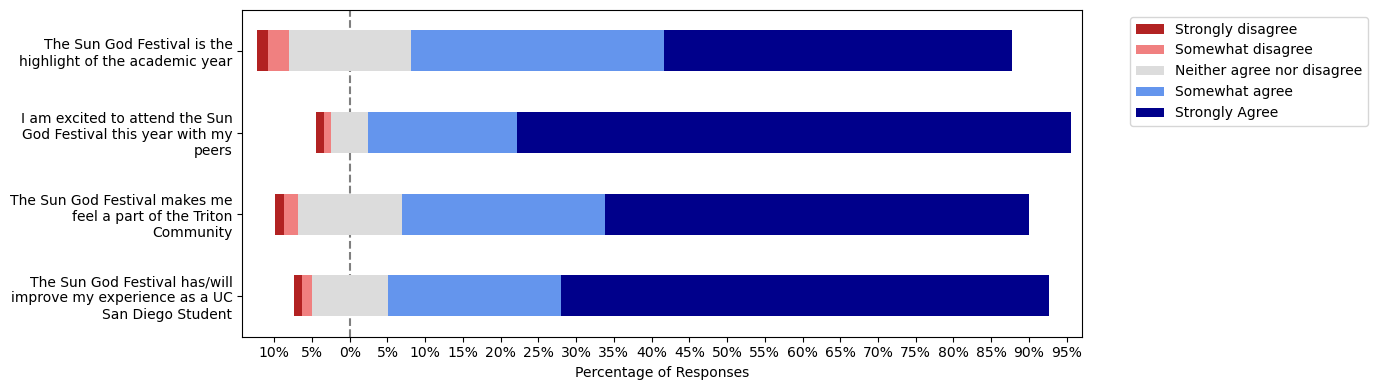

In [8]:
q10data = asce25[['Q10_1', 'Q10_2', 'Q10_3', 'Q10_4']].iloc[2:]
q10data.rename(columns={'Q10_1': 'The Sun God Festival is the highlight of the academic year',
                       'Q10_2': 'I am excited to attend the Sun God Festival this year with my peers',
                       'Q10_3': 'The Sun God Festival makes me feel a part of the Triton Community',
                       'Q10_4': 'The Sun God Festival has/will improve my experience as a UC San Diego Student'}, inplace=True)

# Create a group likert plot based on responses to Sun God Festival sentiment
likert_scale = ['Strongly disagree', 'Somewhat disagree', 'Neither agree nor disagree', 'Somewhat agree','Strongly Agree']
ax = plot_likert.plot_likert(q10data, likert_scale, plot_percentage=True, figsize=(14, 4))
plt.tight_layout()
plt.show()

#### In your own words, how would you describe the Sun God Festival?

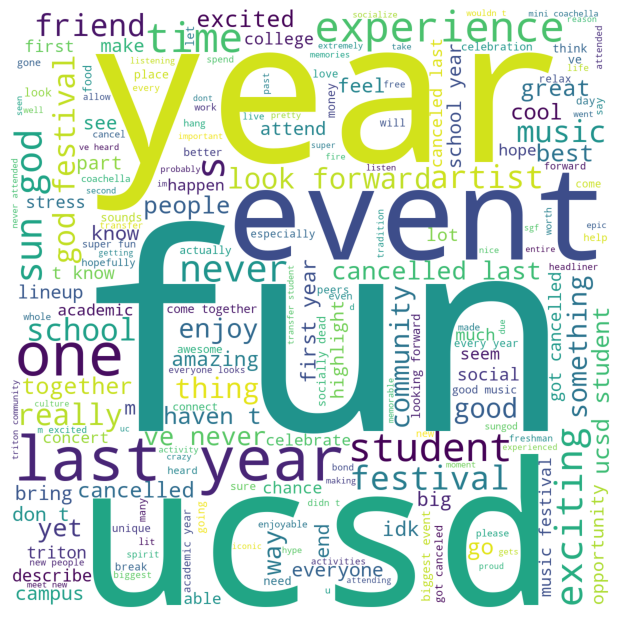

In [9]:
# Remove stop words and tokenize responses
q11data = asce25['Q11.1'].dropna()
comment_words = ''
stopwords = set(STOPWORDS)

for val in q11data:
    val = str(val)
    tokens = val.strip().split()

    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

# Word cloud for how people would describe the Sun God Festival
sgfwordcloud = WordCloud(width=1200, height=1200, background_color='white', stopwords=stopwords, min_font_size=10).generate(comment_words)
              
plt.figure(figsize=(6,6), facecolor=None)
plt.imshow(sgfwordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

<Axes: >

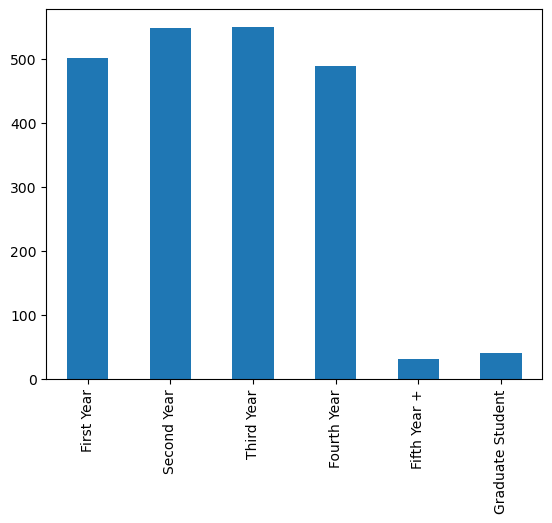

In [10]:
# Distribution of respondents' years
years = ['First Year', 'Second Year', 'Third Year',\
         'Fourth Year', 'Fifth Year +', 'Graduate Student']
mapping = {year: i for i, year in enumerate(years)}

q12data = asce25['Q12'].iloc[2:].map(mapping)
q12data = pd.Categorical(asce25['Q12'].iloc[2:], categories=years, ordered=True)
q12data.value_counts().sort_index().plot(kind='bar')

## Artists Recommended by Students

In [11]:
# Use client details to get access token from Spotify
def get_access_token(SPOTIFY_CLIENT_ID, SPOTIFY_CLIENT_SECRET):
    auth_url = 'https://accounts.spotify.com/api/token'
    auth_header = {
        'Authorization': 'Basic ' + base64.b64encode(f"{SPOTIFY_CLIENT_ID}:{SPOTIFY_CLIENT_SECRET}".encode()).decode()
    }
    auth_data = {'grant_type': 'client_credentials'}
    
    response = requests.post(auth_url, headers=auth_header, data=auth_data)
    return response.json().get('access_token')

# Query for artist ID using names off the survey from Spotify
def get_search_artist(artist_name, SPOTIFY_ACCESS_TOKEN):
    search_url = 'https://api.spotify.com/v1/search'
    headers = {'Authorization': f'Bearer {SPOTIFY_ACCESS_TOKEN}'}
    params = {'q': artist_name, 'type': 'artist', 'limit': 1}
    
    response = requests.get(search_url, headers=headers, params=params)
    artists = response.json().get('artists', {}).get('items', [])
    return artists[0]['id'] if artists else None

# Query for an artist's popularity score using their ID from Spotify
def get_artist_name_popularity(artist_id, SPOTIFY_ACCESS_TOKEN):
    artist_url = f'https://api.spotify.com/v1/artists/{artist_id}'
    headers = {'Authorization': f'Bearer {SPOTIFY_ACCESS_TOKEN}'}
    
    response = requests.get(artist_url, headers=headers)
    return response.json().get('popularity'), response.json().get('name')

load_dotenv()

SPOTIFY_CLIENT_ID = os.getenv('SPOTIFY_CLIENT_ID')
SPOTIFY_CLIENT_SECRET = os.getenv('SPOTIFY_CLIENT_SECRET')
SPOTIFY_ACCESS_TOKEN = get_access_token(SPOTIFY_CLIENT_ID, SPOTIFY_CLIENT_SECRET)

In [12]:
# Remove accents from responses
def remove_accents(text):
    normalized_text = unicodedata.normalize('NFD', text)
    unaccented_text = ''.join(char for char in normalized_text if unicodedata.category(char) != 'Mn')
    return unaccented_text

# Remove emojis from responses
def remove_emojis(text):
    emoji_pattern = re.compile(
        "[\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed Characters
        r"!"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r'', text)

def remove_brackets_onechar(text):
    if '(' in text and ')' in text and text.rindex(')')-text.index('(') > 2:
        text = (text[:text.index('(')] + text[text.rindex(')')+1:]).strip()
    if len(text) < 1:
        return ""
    return text
    
# Chain cleaning for a Series
def clean_artists(x):
    return x.dropna().apply(str.lower).apply(remove_accents).apply(remove_emojis).apply(str.strip)\
            .apply(remove_brackets_onechar).replace(responses_map)


# Combine similar columns from survey, clean them, and save them to file to view progress
def collate_clean_survey_artists(questions, filename):
    # Collate the recommendations for artists and clean them
    artists = pd.concat([asce25[x].iloc[2:] for x in questions], ignore_index=True)
    cleaned_artists = clean_artists(artists)

    # Store the names and counts of artists recommended
    cnts_artists = cleaned_artists.value_counts().reset_index()
    cnts_artists = cnts_artists[cnts_artists['index'] != ""]
    cnts_artists.set_index('index', inplace=True)
    cnts_artists.to_csv(f'data/asce25-raw-{filename}.csv')
    
    return cnts_artists

stemmed_artists = collate_clean_survey_artists(['Q3_1', 'Q3_2', 'Q3_3'], 'artists')
stemmed_up_comers = collate_clean_survey_artists(['Q4_1', 'Q4_2', 'Q4_3'], 'upcomers')

In [13]:
# Clean words from punctuation, accents and casing
def stem_word(x):
    return remove_accents(x.translate(str.maketrans('', '', string.punctuation)).lower()).strip()

# Using Levenshtein distance to fuzzy name match
def find_closest_match(input_name, df, df_column, threshold=2):
    distances = df_column.apply(lambda x: Levenshtein.distance(stem_word(input_name), stem_word(x)))
    
    if distances.empty:
        return None, None, None
    
    min_distance = distances.min()
    min_distance_index = distances.idxmin()
    closest_match = df_column[min_distance_index]

    if min_distance <= threshold:
        return closest_match, min_distance, df.loc[min_distance_index]['count']
    else:
        return None, None, None

# Combine typos by fuzzy matching artists with fewer recommendations to those with more
def fuzzymatch_artist_counts(df):
    with open('data/fuzzy-artist-mistakes.txt', 'r') as f:
        for line in f:
            FUZZY_MISTAKES.append(tuple(line.rstrip().split(',')))

    found, not_found = [], []
    ln = df.shape[0]
    
    # Go over every artist in the count from least to most recommendations
    for i, artist_name in enumerate(reversed(df.index.to_list())):
        threshold = 1 # Edit distance has to be within 1 after cleaning names
        closest_match, distance, ind = find_closest_match(artist_name, df[:ln-i-1], df.index[:ln-i-1].to_series(), threshold)
        
        # Oftentimes found matches with <=4 characters are just different artists with different acronyms
        if closest_match:
            art_stem, clo_stem = stem_word(artist_name), stem_word(closest_match)
            if (art_stem, clo_stem) not in FUZZY_MISTAKES and (clo_stem, art_stem) not in FUZZY_MISTAKES and len(art_stem) > 4:
                df.loc[df.index == artist_name, 'count'] += ind
                df.drop([artist_name], inplace=True)

                found.append((artist_name, closest_match))
            else: not_found.append(artist_name)
        else: not_found.append(artist_name)
    print(found)
    return df

FUZZY_MISTAKES = []
stemmed_artists = fuzzymatch_artist_counts(stemmed_artists)
stemmed_up_comers = fuzzymatch_artist_counts(stemmed_up_comers)

[('violent vera', 'violent vira'), ('fallout boy', 'fall out boy'), ('ryan b.', 'ryan b'), ('infinite song', 'infinity song'), ('young nudy', 'yung nudy'), ('100gecs', '100 gecs'), ('danny lux', 'dannylux'), ('j boog', 'jboog'), ('daniel seavy', 'daniel seavey'), ('trippie redd', 'trippie red'), ('claro', 'clairo'), ('1nlonly', '1nonly'), ('aron may', 'aaron may'), ('marshmello', 'marshmellow'), ('amaare', 'amaarae'), ('caroline polachek', 'caroline polacheck'), (' katseye', 'katseye'), ('ranee rapp', 'renee rapp'), ('the walter’s', 'the walters'), ('duckworth', 'duckwrth'), ('badbunny', 'bad bunny'), ('nikki minaj', 'nicki minaj'), ('nocandy band', 'no candy band'), ('flyana boss', 'flyna boss'), ('one republic', 'onerepublic'), ('adrianne lenker', 'adrienne lenker'), ('baby metal', 'babymetal'), ('steve aoiki', 'steve aoki'), ('make towers', 'myke towers'), ('eric doa', 'ericdoa'), ('claire', 'clairo'), ('my joy', 'mt joy'), ('steve lacey', 'steve lacy'), ('renee rap', 'renee rapp'),

In [14]:
def add_spotify_name_popularity(df):
    df['popularity'] = np.nan
    df['formatted_name'] = np.nan

    prev_pop = pd.read_csv('data/artists-spotify-cached.csv', index_col=0)

    # Query and store each artist's popularity
    try:
        for artist_name in tqdm(df.index):
            try:
                if prev_pop.loc[artist_name].get('popularity', -1) != -1:
                    df.loc[df.index == artist_name, 'popularity'] = prev_pop.loc[artist_name]['popularity']
                    df.loc[df.index == artist_name, 'formatted_name'] = prev_pop.loc[artist_name]['formatted_name']
            except:
                artist_id = get_search_artist(artist_name, SPOTIFY_ACCESS_TOKEN)
                if artist_id:
                    popularity, name = get_artist_name_popularity(artist_id, SPOTIFY_ACCESS_TOKEN)
                    df.loc[df.index == artist_name, 'popularity'] = popularity
                    df.loc[df.index == artist_name, 'formatted_name'] = name
                    prev_pop = pd.concat([prev_pop, pd.DataFrame([[artist_name, name, popularity]], columns=['artist_name', 'formatted_name', 'popularity']).set_index('artist_name')])
                else:
                    print(f"Artist {artist_name} not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

    prev_pop.to_csv('data/artists-spotify-cached.csv')
    return df

stemmed_artists = add_spotify_name_popularity(stemmed_artists)
stemmed_up_comers = add_spotify_name_popularity(stemmed_up_comers)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2464/2464 [00:01<00:00, 1389.12it/s]


In [15]:
# Get rid of duplicates based on formatted name and sum their counts
sum_stemmed_artists = stemmed_artists.groupby("formatted_name").sum(numeric_only=True).reset_index().drop(columns={'popularity'})
sum_stemmed_up_comers = stemmed_up_comers.groupby("formatted_name").sum(numeric_only=True).reset_index().drop(columns={'popularity'})

stemmed_artists = sum_stemmed_artists.drop(columns={'count'})\
                    .merge(stemmed_artists.drop_duplicates(subset=['formatted_name']), how='left', on='formatted_name')
stemmed_up_comers = sum_stemmed_up_comers.drop(columns={'count'})\
                    .merge(stemmed_up_comers.drop_duplicates(subset=['formatted_name']), how='left', on='formatted_name')

stemmed_artists = stemmed_artists.set_index(stemmed_artists['formatted_name'].apply(stem_word))
stemmed_up_comers = stemmed_up_comers.set_index(stemmed_up_comers['formatted_name'].apply(stem_word))

stemmed_artists.index.names, stemmed_up_comers.index.names = ['index'], ['index']

In [16]:
# Convert JSON from more human readable {'year': ['artists']} format to more practical {'artist': ['years'] format
def get_prev_artists(paths):
    prev_artists = defaultdict(set)
    
    for path in paths:
        with open(path) as prev_artists_file:
            prev_artists_raw = json.load(prev_artists_file)

        for year in prev_artists_raw:
            for artist in prev_artists_raw[year]:
                prev_artists[artist].add(year)
    return prev_artists

def add_prev_ucsd_artists(df):
    # Dictionary of artists that have previously been to UCSD for ASCE
    prev_artists = get_prev_artists(['data/previous-sgf-artists.json', 'data/previous-misc-artists.json'])

    year_buckets_relative = [1, 3, 5, 10, 15, 20, 30]
    current_year = datetime.now().year
    year_buckets = [current_year-x+1 for x in year_buckets_relative]

    df['Year'] = np.nan
    df['Most Recent Year'] = "Has not been to UCSD for ASCE"
    found, not_found = [], []

    # Add all years and text for the most recent bucket of years an artist has come, if they have come
    for artist_name in prev_artists:
        threshold = 1
        closest_match, distance, ind = find_closest_match(artist_name, df, df.index.to_series(), threshold)
        
        if closest_match:
            art_stem, clo_stem = stem_word(artist_name), stem_word(closest_match)
            if (art_stem, clo_stem) not in FUZZY_MISTAKES and (clo_stem, art_stem) not in FUZZY_MISTAKES and len(art_stem) > 4:
                recent_year = sorted(prev_artists[artist_name])[-1]
                recent_bucket = next((x[0] for x in enumerate(year_buckets_relative) if x[1] > current_year-int(recent_year)), -1)
                df.loc[df.index == stem_word(artist_name), 'Most Recent Year'] = \
                    f"Last {year_buckets_relative[recent_bucket]} Year{'s' if recent_bucket > 0 else ''}"\
                    if recent_bucket != -1 else "Been to UCSD for ASCE"
                df.loc[df.index == stem_word(artist_name), 'Year'] = ", ".join(sorted(prev_artists[artist_name]))
                found.append((artist_name, closest_match))
            else: not_found.append(artist_name)
        else: not_found.append(artist_name)
    print(f'Found {len(found)} matches, such as {found[0]}')
    return df

stemmed_artists = add_prev_ucsd_artists(stemmed_artists)
stemmed_up_comers = add_prev_ucsd_artists(stemmed_up_comers)

Found 49 matches, such as ('They Might Be Giants', 'they might be giants')
Found 46 matches, such as ('My Chemical Romance', 'my chemical romance')


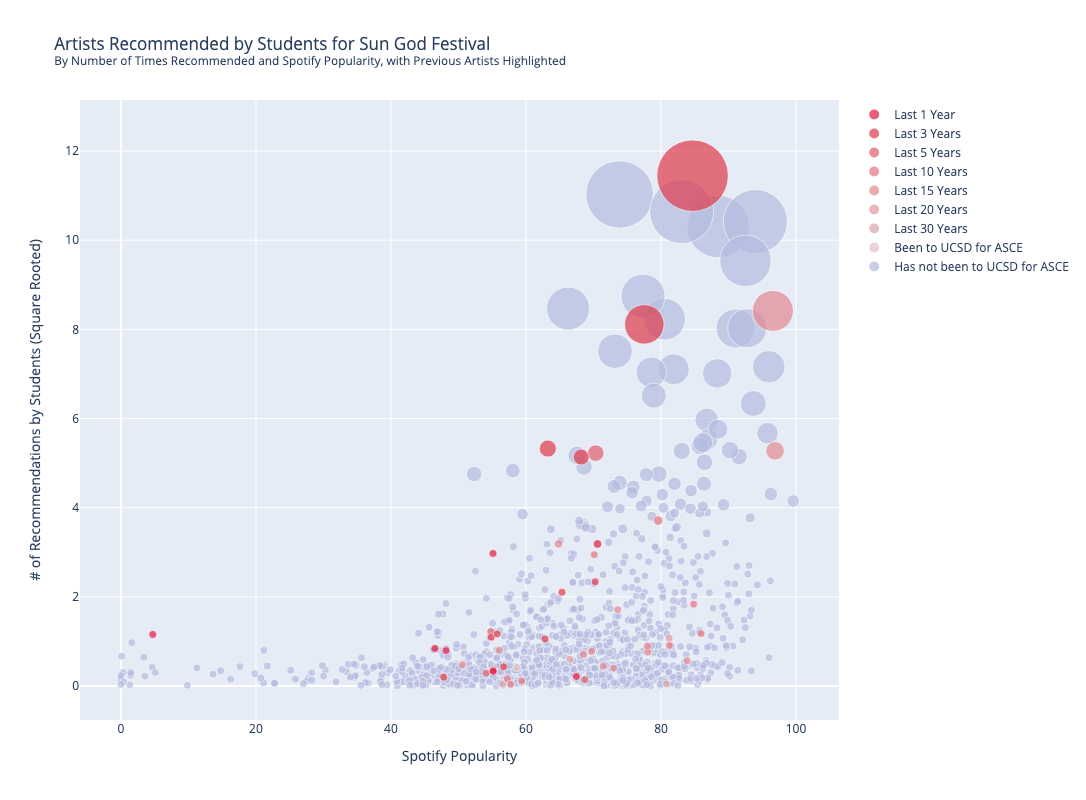

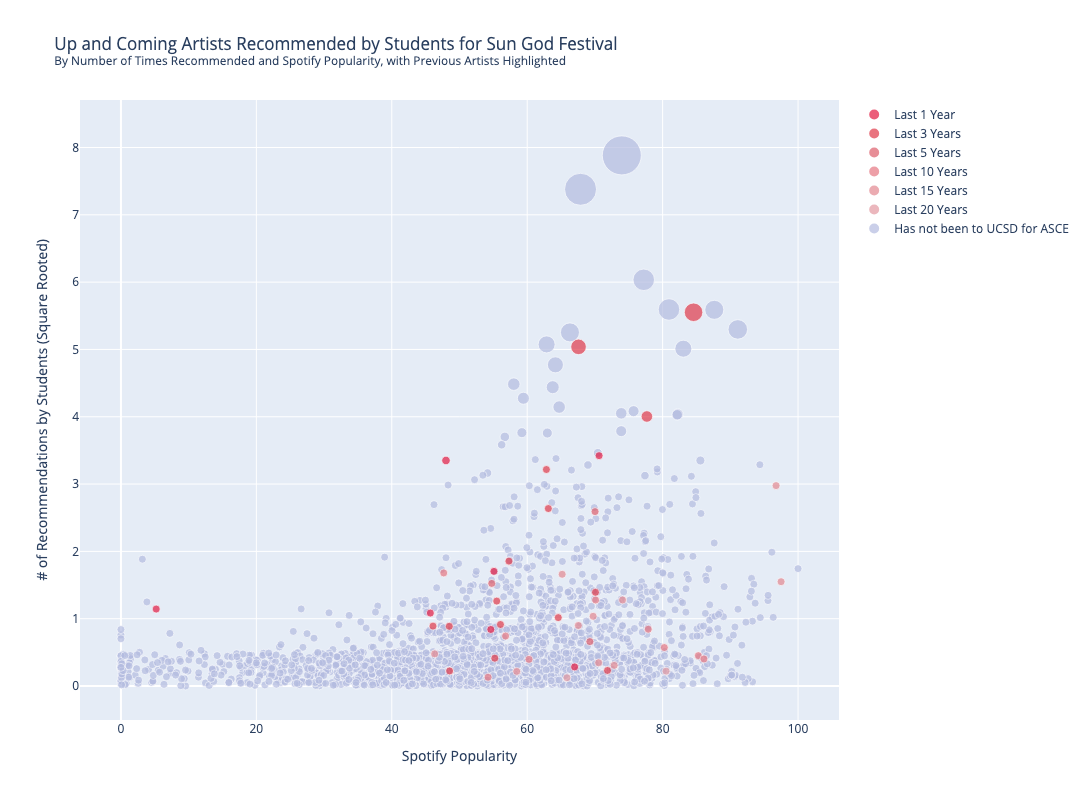

In [17]:
# Randomize plot points for Spotify popularity slightly (X-axis)
def rand_pop(x):
    return min(max(x+0.5-random.uniform(0, 1), 0), 100)

# Randomize plot points for # of recommendations slightly (Y-axis)
def rand_rec(y):
    return min(max(y-0.5-random.uniform(0, 0.5), 0), 100)

def create_artist_by_recs_spotify_bubble(df, title_type):
    # Gradient based on how recently they've come, or an opposite colour if they haven't
    color_map={'Last 1 Year': '#e31b43',
               'Last 3 Years': '#e03a4a',
               'Last 5 Years': '#de5f6c',
               'Last 10 Years': '#e67782',
               'Last 15 Years': '#e38891',
               'Last 20 Years': '#e39aa2',
               'Last 30 Years': '#dba4aa',
               'Been to UCSD for ASCE': '#e6c1c5',
               'Has not been to UCSD for ASCE': '#b4bce0'
              }

    df.rename(columns={'count': '# of Recommendations by Students',
                       'popularity': 'Spotify Popularity',
                       'formatted_name': 'Artist Name'}, inplace=True)
    df['Mod Popularity'] = df['Spotify Popularity'].apply(rand_pop)

    # Create scatter plot, layering the most recent artists on top of the older appearances/those who never came to UCSD
    fig = go.Figure()
    for ind, year_group in enumerate(reversed(color_map.keys())):
        data_subset = df[df['Most Recent Year'] == year_group]

        fig.add_trace(go.Scatter(
            x=data_subset['Mod Popularity'],
            y=data_subset['# of Recommendations by Students'].apply(np.sqrt).apply(rand_rec), # Scale data with square root
            mode='markers',
            marker=dict(
                size=data_subset['# of Recommendations by Students'],
                sizemode='diameter',
                sizemin=4,
                sizeref=2.0,
                color=data_subset['Most Recent Year'].map(color_map)
            ),
            legendrank=-ind,
            customdata=data_subset[['Artist Name', 'Most Recent Year', '# of Recommendations by Students', 'Spotify Popularity']],
            name=year_group,
        ))

    # Titles and styling
    fig.update_layout(
        title={
            'text': f"{title_type} Recommended by Students for Sun God Festival<br>"
                    "<sup>By Number of Times Recommended and Spotify Popularity, with Previous Artists Highlighted</sup>",
        },
        xaxis=dict(title="Spotify Popularity"),
        yaxis=dict(title="# of Recommendations by Students (Square Rooted)"),
        height=800,
        width=1200,
        hoverlabel=dict(
            font=dict(color="#222"),
            bordercolor="white",
        ),
        legend= {'itemsizing': 'constant'}
    )

    # Custom tooltip for the bubbles
    fig.update_traces(marker=dict(line=dict(color='white', width=0.75)))
    fig.update_traces(
        hovertemplate=(
            "<br><b>%{customdata[0]}</b><br>—<br>"
            "%{customdata[1]}<br>"
            "%{customdata[2]} // Number of Recommendations by Students<br>"
            "%{customdata[3]} // Spotify Popularity<br><br>"
            "<extra></extra>"
        )
    )

    # Lighten the background colour of each hover label by about half
    for trace in fig.data:
        trace_name = trace.name
        if trace_name in color_map:
            rgba = mcolors.to_rgba(color_map[trace_name], alpha=0.5)
            rgb = [str(255*(1-(1-x)/2)) for x in rgba][:3]
            trace.hoverlabel = dict(bgcolor='rgb('+','.join(rgb[:3])+')')
    fig.show()

create_artist_by_recs_spotify_bubble(stemmed_artists, "Artists")
create_artist_by_recs_spotify_bubble(stemmed_up_comers, "Up and Coming Artists")